In [1]:
import pandas as pd
import numpy as np

def format_func(value, tick_number):
    if value == 0:
        return "0"
    elif value >= 1000:
        return f"{int(value/1000)}k"
    else:
        return str(int(value))

def get_metric_values(df, input_type, metric_name):
    if input_type not in df["input_type"].unique():
        raise ValueError(f"'{input_type}' is not a valid input_type. "
                         f"Available: {df['input_type'].unique().tolist()}")
    if metric_name not in df["metric_name"].unique():
        raise ValueError(f"'{metric_name}' is not a valid metric_name. "
                         f"Available: {df['metric_name'].unique().tolist()}")
    
    metric_values = df[(df["input_type"] == input_type) &
                       (df["metric_name"] == metric_name)]["value"]
    return metric_values.values

def read_metrics(experiment_key: str) -> [pd.DataFrame, int]:
    experiment_metrics = pd.read_csv(f"loggs/{experiment_key}/metrics.csv")
    num_logged_epochs = experiment_metrics["epoch"].max() + 1
    return experiment_metrics, num_logged_epochs

def get_model_norm(results):
    return results[results["metric_name"] == "weights_l2"] \
        .groupby("epoch")["value"] \
        .apply(lambda x: np.sqrt((x**2).sum())).values

In [4]:
log_frequency = 1

lr = 0.01
wd = 4

experiment_key = f'add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-{wd}.0'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

test_acc = get_metric_values(experiment_metrics, "test", "accuracy")
test_acc

array([6.39519701e-03, 5.61211165e-03, 4.04594094e-03, 4.30696923e-03,
       4.82902629e-03, 3.26285558e-03, 2.34925607e-03, 1.43565645e-03,
       9.13599564e-04, 6.52571092e-04, 5.22056886e-04, 3.91542679e-04,
       1.30514221e-04, 0.00000000e+00, 1.30514221e-04, 1.30514221e-04,
       1.30514221e-04, 1.30514221e-04, 1.30514221e-04, 1.30514221e-04,
       1.30514221e-04, 2.61028443e-04, 2.61028443e-04, 2.61028443e-04,
       2.61028443e-04, 1.30514221e-04, 1.30514221e-04, 1.30514221e-04,
       0.00000000e+00, 0.00000000e+00, 1.30514221e-04, 1.30514221e-04,
       0.00000000e+00, 0.00000000e+00, 2.61028443e-04, 5.22056886e-04,
       1.30514221e-04, 2.61028443e-04, 3.91542679e-04, 2.61028443e-04,
       3.91542679e-04, 3.91542679e-04, 3.91542679e-04, 3.91542679e-04,
       5.22056886e-04, 3.91542679e-04, 3.91542679e-04, 6.52571092e-04,
       5.22056886e-04, 3.91542679e-04, 5.22056886e-04, 3.91542679e-04,
       5.22056886e-04, 6.52571092e-04, 5.22056886e-04, 9.13599564e-04,
      

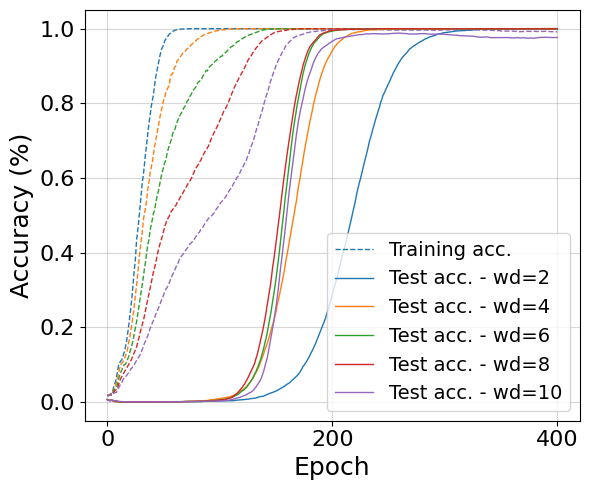

In [59]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []

for wd in range(2, 12, 2):
    experiment_key = f'add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-{wd}.0'
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(epochs, train_acc[0], linestyle='--', linewidth=1, label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc, linestyle='--', linewidth=1)

plt.gca().set_prop_cycle(None)

for wd, acc in zip(range(2, 12, 2), test_acc):
    ax.plot(epochs, acc, linewidth=1, label=f'Test acc. - wd={wd}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_experiments.png')
plt.show()

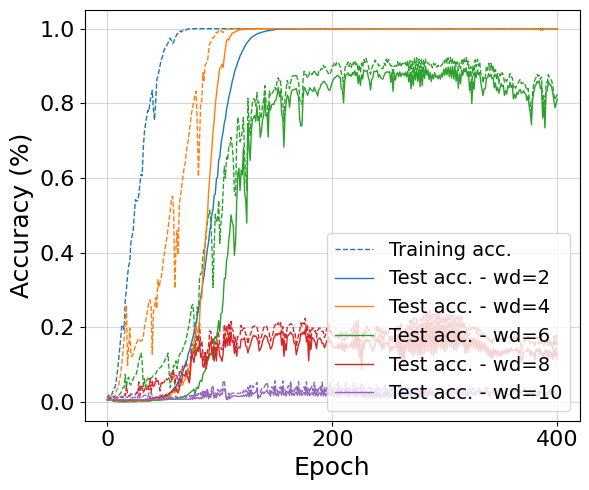

In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []

for wd in range(2, 12, 2):
    experiment_key = f'add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-{wd}.0'
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(epochs, train_acc[0], linestyle='--', linewidth=1, label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc, linestyle='--', linewidth=1)

plt.gca().set_prop_cycle(None)

for wd, acc in zip(range(2, 12, 2), test_acc):
    ax.plot(epochs, acc, linewidth=1, label=f'Test acc. - wd={wd}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_experiments.png')
plt.show()

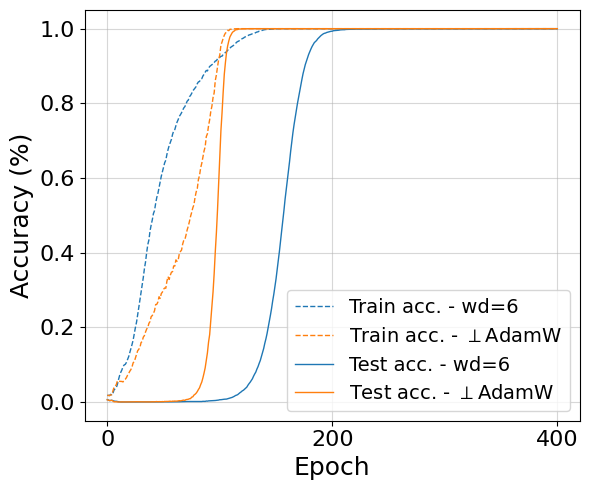

In [60]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
wd = 6

fig, ax = plt.subplots(figsize=(6, 5))

experiment_key = f'add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-{wd}.0'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

wd_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
wd_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

experiment_key = 'add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|orthogonal_gradients-True'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)

ortho_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
ortho_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

ax.plot(epochs, wd_train_acc, linestyle='--', linewidth=1, label=f'Train acc. - wd={wd}')
ax.plot(epochs, ortho_train_acc, linestyle='--', linewidth=1, label=r'Train acc. - $\perp$AdamW')

plt.gca().set_prop_cycle(None)

ax.plot(epochs, wd_test_acc, linewidth=1, label=f'Test acc. - wd={wd}')
ax.plot(epochs, ortho_test_acc, linewidth=1, label=r'Test acc. - $\perp$AdamW')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_vs_ortho.png')
plt.show()

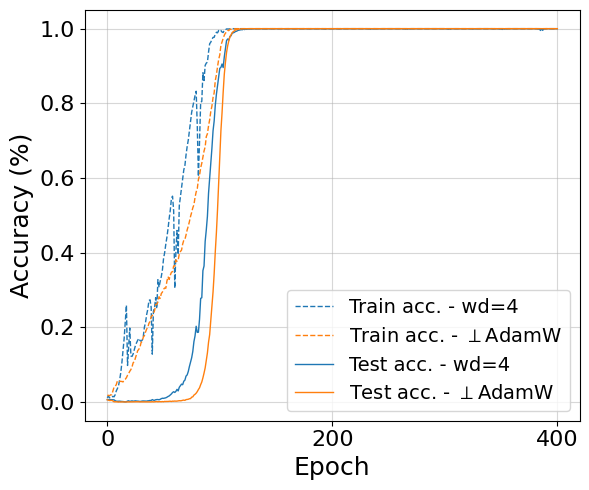

In [52]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
wd = 4

fig, ax = plt.subplots(figsize=(6, 5))

experiment_key = f'add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-{wd}.0'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

wd_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
wd_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

experiment_key = 'add_mod|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|orthogonal_gradients-True'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)

ortho_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
ortho_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

ax.plot(epochs, wd_train_acc, linestyle='--', linewidth=1, label=f'Train acc. - wd={wd}')
ax.plot(epochs, ortho_train_acc, linestyle='--', linewidth=1, label=r'Train acc. - $\perp$AdamW')

plt.gca().set_prop_cycle(None)

ax.plot(epochs, wd_test_acc, linewidth=1, label=f'Test acc. - wd={wd}')
ax.plot(epochs, ortho_test_acc, linewidth=1, label=r'Test acc. - $\perp$AdamW')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_vs_ortho.png')
plt.show()

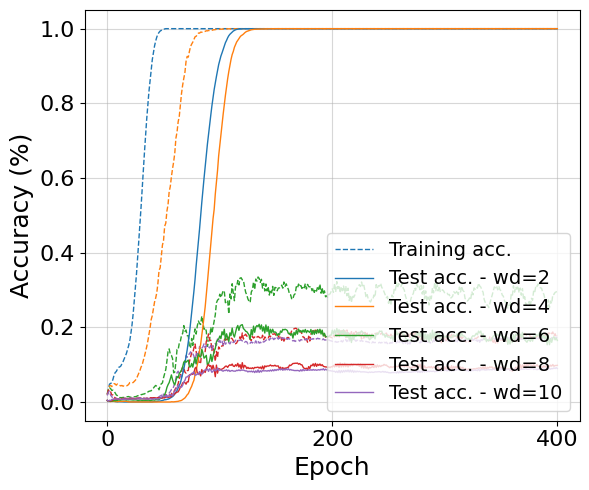

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []

for wd in range(2, 12, 2):
    experiment_key = f'add_mod|hidden_sizes-[200]|num_epochs-401|train_fraction-0.4|input_size-100|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-{wd}.0|use_embedding-True'
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(epochs, train_acc[0], linestyle='--', linewidth=1, label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc, linestyle='--', linewidth=1)

plt.gca().set_prop_cycle(None)

for wd, acc in zip(range(2, 12, 2), test_acc):
    ax.plot(epochs, acc, linewidth=1, label=f'Test acc. - wd={wd}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_1_layer_embedding_experiments.png')
plt.show()


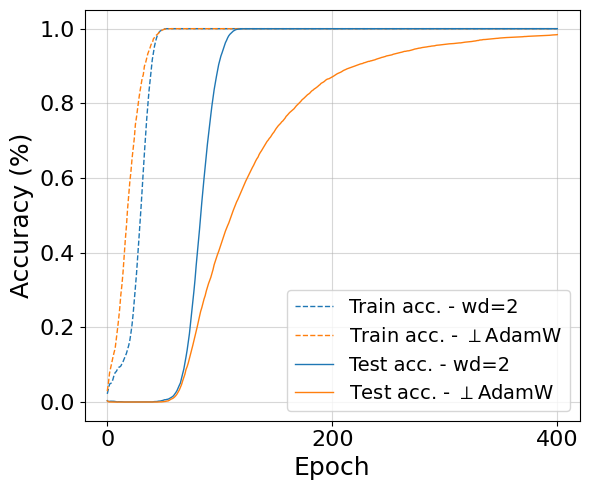

In [55]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
wd = 2

fig, ax = plt.subplots(figsize=(6, 5))

experiment_key = f'add_mod|hidden_sizes-[200]|num_epochs-401|train_fraction-0.4|input_size-100|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-{wd}.0|use_embedding-True'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

wd_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
wd_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

experiment_key = 'add_mod|hidden_sizes-[200]|num_epochs-401|train_fraction-0.4|input_size-100|log_frequency-1|lr-0.01|batch_size-5107|orthogonal_gradients-True|use_embedding-True'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)

ortho_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
ortho_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

ax.plot(epochs, wd_train_acc, linestyle='--', linewidth=1, label=f'Train acc. - wd={wd}')
ax.plot(epochs, ortho_train_acc, linestyle='--', linewidth=1, label=r'Train acc. - $\perp$AdamW')

plt.gca().set_prop_cycle(None)

ax.plot(epochs, wd_test_acc, linewidth=1, label=f'Test acc. - wd={wd}')
ax.plot(epochs, ortho_test_acc, linewidth=1, label=r'Test acc. - $\perp$AdamW')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_vs_ortho_1_layer_embedding.png')
plt.show()

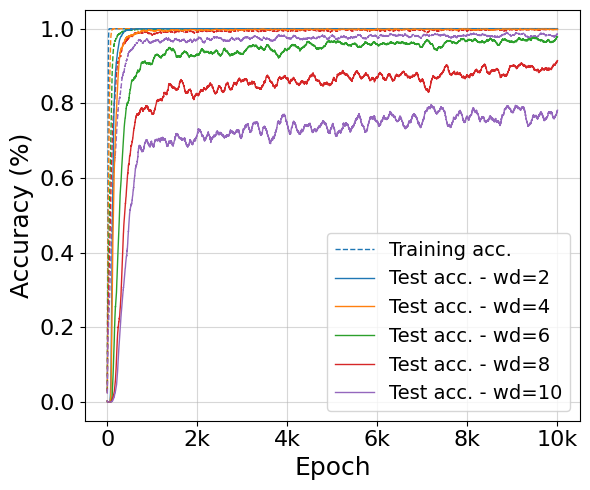

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []

for wd in range(2, 12, 2):
    experiment_key = f'add_mod|hidden_sizes-[200]|num_epochs-10001|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-{wd}.0'
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(epochs, train_acc[0], linestyle='--', linewidth=1, label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc, linestyle='--', linewidth=1)

plt.gca().set_prop_cycle(None)

for wd, acc in zip(range(2, 12, 2), test_acc):
    ax.plot(epochs, acc, linewidth=1, label=f'Test acc. - wd={wd}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::2000])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_1_layer_experiments.png')
plt.show()


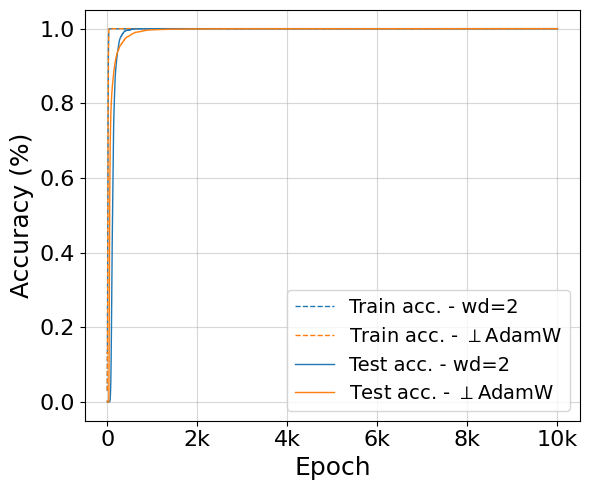

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
wd = 2

fig, ax = plt.subplots(figsize=(6, 5))

experiment_key = f'add_mod|hidden_sizes-[200]|num_epochs-10001|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|weight_decay-{wd}.0'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

wd_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
wd_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

experiment_key = 'add_mod|hidden_sizes-[200]|num_epochs-10001|train_fraction-0.4|log_frequency-1|lr-0.05|batch_size-5107|orthogonal_gradients-True'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)

ortho_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
ortho_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

ax.plot(epochs, wd_train_acc, linestyle='--', linewidth=1, label=f'Train acc. - wd={wd}')
ax.plot(epochs, ortho_train_acc, linestyle='--', linewidth=1, label=r'Train acc. - $\perp$AdamW')

plt.gca().set_prop_cycle(None)

ax.plot(epochs, wd_test_acc, linewidth=1, label=f'Test acc. - wd={wd}')
ax.plot(epochs, ortho_test_acc, linewidth=1, label=r'Test acc. - $\perp$AdamW')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::2000])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_vs_ortho_1_layer.png')
plt.show()

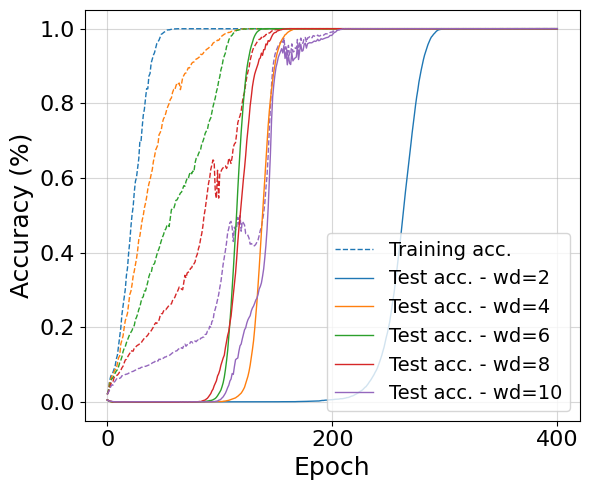

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []

for wd in range(2, 12, 2):
    experiment_key = f'add_mod|num_epochs-401|train_fraction-0.4|input_size-100|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-{wd}.0|use_embedding-True'
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(epochs, train_acc[0], linestyle='--', linewidth=1, label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc, linestyle='--', linewidth=1)

plt.gca().set_prop_cycle(None)

for wd, acc in zip(range(2, 12, 2), test_acc):
    ax.plot(epochs, acc, linewidth=1, label=f'Test acc. - wd={wd}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_embedding_experiments.png')
plt.show()

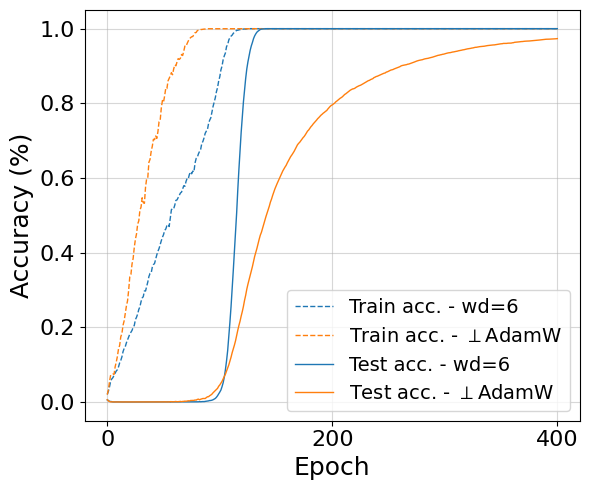

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
wd = 6

fig, ax = plt.subplots(figsize=(6, 5))

experiment_key = f'add_mod|num_epochs-401|train_fraction-0.4|input_size-100|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-{wd}.0|use_embedding-True'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

wd_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
wd_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

experiment_key = 'add_mod|num_epochs-401|train_fraction-0.4|input_size-100|log_frequency-1|lr-0.01|batch_size-5107|orthogonal_gradients-True|use_embedding-True'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)

ortho_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
ortho_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

ax.plot(epochs, wd_train_acc, linestyle='--', linewidth=1, label=f'Train acc. - wd={wd}')
ax.plot(epochs, ortho_train_acc, linestyle='--', linewidth=1, label=r'Train acc. - $\perp$AdamW')

plt.gca().set_prop_cycle(None)

ax.plot(epochs, wd_test_acc, linewidth=1, label=f'Test acc. - wd={wd}')
ax.plot(epochs, ortho_test_acc, linewidth=1, label=r'Test acc. - $\perp$AdamW')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_vs_ortho_embedding.png')
plt.show()

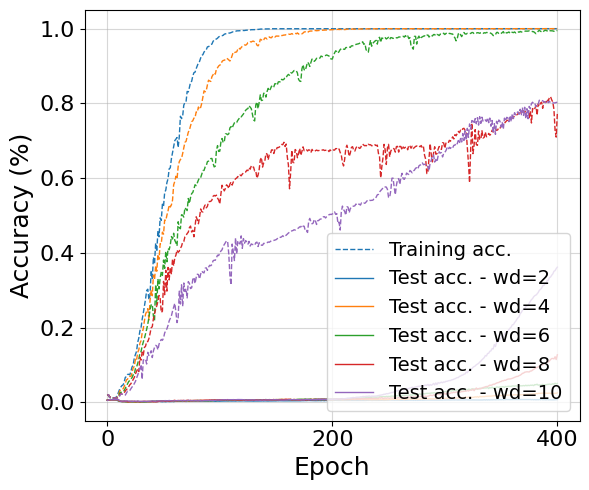

In [57]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []

for wd in range(2, 12, 2):
    experiment_key = f'add_mod|hidden_sizes-[200, 200, 200]|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.005|batch_size-5107|weight_decay-{wd}.0'
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(epochs, train_acc[0], linestyle='--', linewidth=1, label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc, linestyle='--', linewidth=1)

plt.gca().set_prop_cycle(None)

for wd, acc in zip(range(2, 12, 2), test_acc):
    ax.plot(epochs, acc, linewidth=1, label=f'Test acc. - wd={wd}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_3_layer_experiments.png')
plt.show()


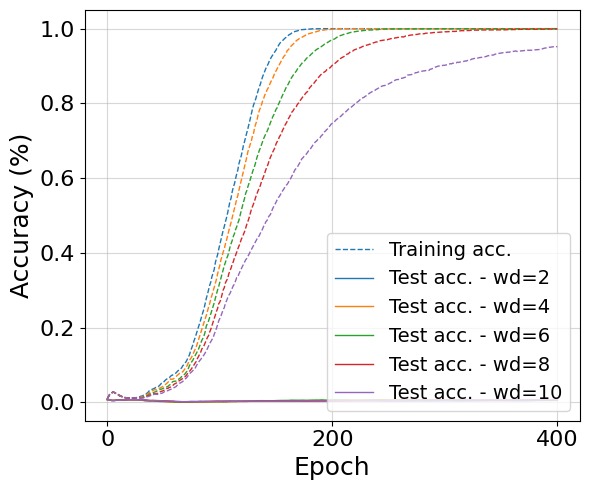

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []

for wd in range(2, 12, 2):
    experiment_key = f'add_mod|hidden_sizes-[200, 200, 200]|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.001|batch_size-5107|weight_decay-{wd}.0'
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(epochs, train_acc[0], linestyle='--', linewidth=1, label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc, linestyle='--', linewidth=1)

plt.gca().set_prop_cycle(None)

for wd, acc in zip(range(2, 12, 2), test_acc):
    ax.plot(epochs, acc, linewidth=1, label=f'Test acc. - wd={wd}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_3_layer_experiments.png')
plt.show()


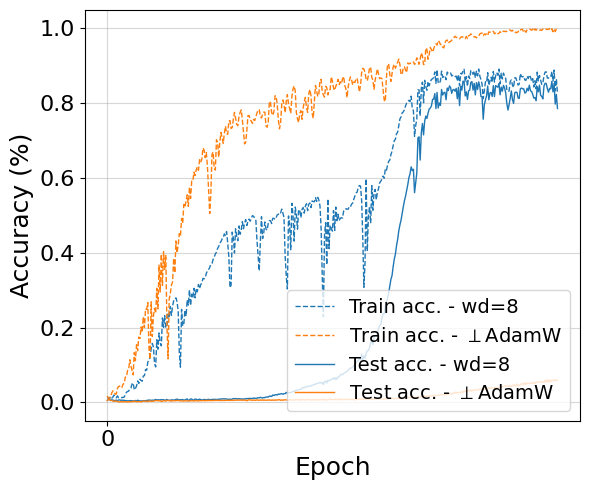

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
wd = 8

fig, ax = plt.subplots(figsize=(6, 5))

experiment_key = f'add_mod|hidden_sizes-[200, 200, 200]|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|weight_decay-{wd}.0'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

wd_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
wd_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

experiment_key = 'add_mod|hidden_sizes-[200, 200, 200]|num_epochs-401|train_fraction-0.4|log_frequency-1|lr-0.01|batch_size-5107|orthogonal_gradients-True'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)

ortho_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
ortho_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

ax.plot(epochs, wd_train_acc, linestyle='--', linewidth=1, label=f'Train acc. - wd={wd}')
ax.plot(epochs, ortho_train_acc, linestyle='--', linewidth=1, label=r'Train acc. - $\perp$AdamW')

plt.gca().set_prop_cycle(None)

ax.plot(epochs, wd_test_acc, linewidth=1, label=f'Test acc. - wd={wd}')
ax.plot(epochs, ortho_test_acc, linewidth=1, label=r'Test acc. - $\perp$AdamW')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::2000])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_vs_ortho_3_layer.png')
plt.show()

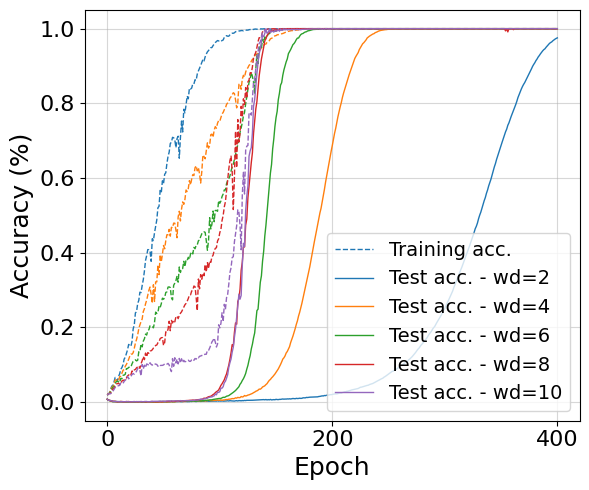

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
train_acc = []
test_acc = []

for wd in range(2, 12, 2):
    experiment_key = f'add_mod|hidden_sizes-[200, 200, 200]|num_epochs-401|train_fraction-0.4|input_size-100|log_frequency-1|lr-0.005|batch_size-5107|weight_decay-{wd}.0|use_embedding-True'
    experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
    epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

    train_acc.append(get_metric_values(experiment_metrics, "train", "accuracy"))
    test_acc.append(get_metric_values(experiment_metrics, "test", "accuracy"))

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(epochs, train_acc[0], linestyle='--', linewidth=1, label='Training acc.')
for acc in train_acc[1:]:
    ax.plot(epochs, acc, linestyle='--', linewidth=1)

plt.gca().set_prop_cycle(None)

for wd, acc in zip(range(2, 12, 2), test_acc):
    ax.plot(epochs, acc, linewidth=1, label=f'Test acc. - wd={wd}')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_3_layer_embedding_experiments.png')
plt.show()


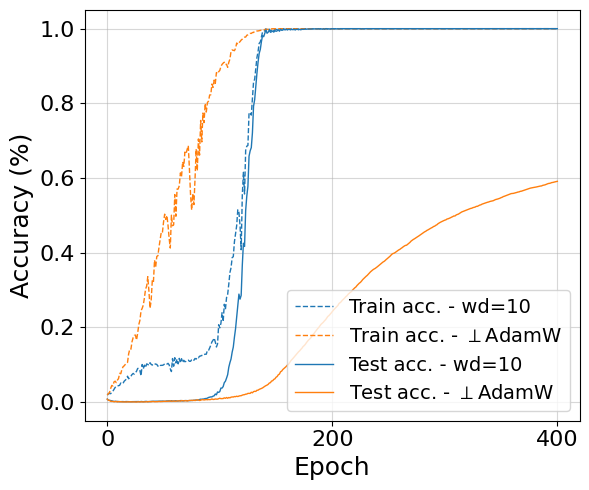

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

log_frequency = 1
wd = 10

fig, ax = plt.subplots(figsize=(6, 5))

experiment_key = f'add_mod|hidden_sizes-[200, 200, 200]|num_epochs-401|train_fraction-0.4|input_size-100|log_frequency-1|lr-0.005|batch_size-5107|weight_decay-{wd}.0|use_embedding-True'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
epochs = range(0, log_frequency * (num_logged_epochs), log_frequency)

wd_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
wd_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

experiment_key = 'add_mod|hidden_sizes-[200, 200, 200]|num_epochs-401|train_fraction-0.4|input_size-100|log_frequency-1|lr-0.005|batch_size-5107|orthogonal_gradients-True|use_embedding-True'
experiment_metrics, num_logged_epochs = read_metrics(experiment_key)

ortho_train_acc = get_metric_values(experiment_metrics, "train", "accuracy")
ortho_test_acc = get_metric_values(experiment_metrics, "test", "accuracy")

ax.plot(epochs, wd_train_acc, linestyle='--', linewidth=1, label=f'Train acc. - wd={wd}')
ax.plot(epochs, ortho_train_acc, linestyle='--', linewidth=1, label=r'Train acc. - $\perp$AdamW')

plt.gca().set_prop_cycle(None)

ax.plot(epochs, wd_test_acc, linewidth=1, label=f'Test acc. - wd={wd}')
ax.plot(epochs, ortho_test_acc, linewidth=1, label=r'Test acc. - $\perp$AdamW')

ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy (%)', fontsize=18)

ax.grid(alpha=0.5)
ax.legend(fontsize=14, loc="lower right")

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xticks(epochs[::200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('wd_vs_ortho_3_layer_embedding.png')
plt.show()